In [4]:
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image 

from skimage import color

In [2]:
!pip3 install scikit-image

     |████████████████████████████████| 12.1 MB 172 kB/s eta 0:00:01    |████████████████▉               | 6.3 MB 206 kB/s eta 0:00:281 MB 61 kB/s eta 0:00:15
     |████████████████████████████████| 152 kB 87 kB/s eta 0:00:01
  Using cached imageio-2.9.0-py3-none-any.whl (3.3 MB)
     |████████████████████████████████| 4.3 MB 145 kB/s eta 0:00:01     |██████████████                  | 1.9 MB 179 kB/s eta 0:00:14
     |████████████████████████████████| 1.6 MB 102 kB/s eta 0:00:01
You should consider upgrading via the '/Users/amritpalsingh/Documents/Capstone/capstone_env/bin/python -m pip install --upgrade pip' command.


(64, 64, 3)

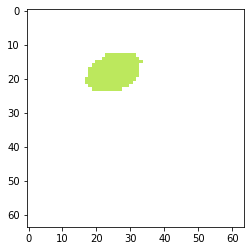

In [5]:
img = np.full((64,64,3), 255, dtype=np.uint8)
center_x = np.random.randint(10,54)
center_y = np.random.randint(10,54)
major_axis = np.random.randint(1,9)
minor_axis= np.random.randint(1,9)
angle = np.random.randint(0,360)
B = np.random.randint(0,254)
G = np.random.randint(0,254)
R = np.random.randint(0,254)
a = cv2.ellipse(img, (center_x, center_y), (major_axis, minor_axis), angle, 0, 360, (B, G, R), -1)
plt.imshow(a)
a.shape

In [6]:
def next_batch(batch_size):
    elipse = np.ndarray(shape=(batch_size,64,64,3), dtype=np.uint8)
    labels = np.ndarray(shape=(batch_size,2), dtype=np.uint8)
    for j in range(batch_size):
        img = np.full((64,64,3), 255, dtype=np.uint8)
        center_x = np.random.randint(10,54)
        center_y = np.random.randint(10,54)
        center = np.array([center_x, center_y])
        major_axis = np.random.randint(1,9)
        minor_axis=np.random.randint(1,9)
        angle = np.random.randint(0,360)
        B = np.random.randint(0,255)
        G = np.random.randint(0,255)
        R = np.random.randint(0,255)
        my_elipse = cv2.ellipse(img, (center_x, center_y), (major_axis, minor_axis), angle, 0, 360, (B, G, R), -1)
        elipse[j,:,:,:] = my_elipse
        labels[j,:] = center
    no_elipse = np.full((batch_size ,64,64,3), 255, dtype=np.uint8) # image of 64x64 with white background
    no_elipse_labels = np.zeros(shape=(batch_size,2), dtype=np.uint8)
    # classification labels
    class_elipse_labels = np.ones(shape=(batch_size,1), dtype=np.uint8)
    class_no_elipse_labels = np.zeros(shape=(batch_size,1), dtype=np.uint8)
    class_labels = np.concatenate([class_elipse_labels, class_no_elipse_labels])
    labels = np.concatenate([labels,no_elipse_labels])
    labels = np.concatenate([labels, class_labels], axis=1)
    return np.concatenate([elipse,no_elipse]), labels
batch_size = 64
images, labels = next_batch(batch_size)


(1, (128, 64, 64, 3), (128, 3))

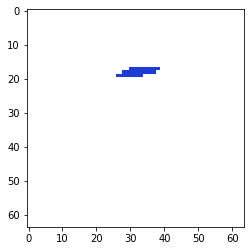

In [8]:
plt.imshow(images[62,:,:,:])
labels[62,2], images.shape, labels.shape


In [9]:
num_hidden = 64 # hidden nodes
image_size = 64 #
num_channels = 3
alpha = 0.95
num_labels = 3

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size*2, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size*2, num_labels))
  tf_valid_dataset = tf.placeholder(tf.float32, shape=(batch_size*2, image_size, image_size, num_channels))
  tf_valid_labels = tf.placeholder(tf.float32, shape=(batch_size*2, num_labels))
  tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size*2, image_size, image_size, num_channels))
  tf_test_labels = tf.placeholder(tf.float32, shape=(batch_size*2, num_labels))


  #tf_test_labels= tf.Variable(test_labels)

  def model(data):    
      conv11 = tf.contrib.layers.conv2d(data, num_outputs=1, kernel_size=(1,1),activation_fn=None)
      conv11_2 = tf.contrib.layers.conv2d(tf_train_dataset, num_outputs=1, kernel_size=(1,1),activation_fn=tf.sigmoid)
      drop = tf.nn.dropout(conv11_2, 0.5)
      conv11_2flat = tf.layers.flatten(drop)
      dense1 = tf.layers.dense(conv11_2flat, 128, activation = tf.nn.relu)
      dense2 = tf.layers.dense(dense1, 2)
      return dense2
  def model_class(data):
      data = tf.layers.flatten(data)
      dense1 = tf.layers.dense(data, 128)
      dense2 = tf.layers.dense(dense1, 1, use_bias=True, activation = tf.sigmoid)
      dense2 = tf.transpose(dense2)
      return dense2


  #Loss definition
  logits = model(tf_train_dataset)
  logits_class = model_class(tf_train_dataset)
    
  loss1 = tf.reduce_mean(tf.reduce_sum((tf_train_labels[:,:2]-logits[:,:2])**2,axis=1)) 
  loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels[:,2], logits=logits_class))
  loss = (alpha * loss1) + ((1-alpha) * loss2) 
    

   

  # Optimizer
  optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


In [10]:
num_steps = 20001
    
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized weights ,biases and other variables')
  for step in range(num_steps):
    batch_data, batch_labels = next_batch(batch_size)
#preprocessing for image
    batch_data = 255-batch_data
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions, elipse = session.run(  [optimizer, loss, logits, logits_class], feed_dict=feed_dict)
    elipse.shape
    if (step % 200 == 0):
      print('Training batch loss at step %d: %f' % (step, l))
      print('ground truth of elipse center is', batch_labels[2, :2])
      print('Prediction of elipse centers is:', predictions[2,:])
      print('ground truth if elipse is:' ,batch_labels[2, 2])
      print('prediction if elipse or not', elipse[:, 2], elipse[:, 100])  
  test_data, test_label = next_batch(batch_size)
  #preprocessing for image
  test_data = 255-test_data
  feed_dict={tf_train_dataset:test_data, tf_train_labels : test_label}
  predictions, elipse = session.run(  [logits, logits_class], feed_dict=feed_dict)


Initialized weights ,biases and other variables
Training batch loss at step 0: 1153.229004
ground truth of elipse center is [33 10]
Prediction of elipse centers is: [-0.38096166  3.1198921 ]
ground truth if elipse is: 1
prediction if elipse or not [1.] [0.5]
Training batch loss at step 200: 615.505798
ground truth of elipse center is [47 31]
Prediction of elipse centers is: [12.953655 14.701826]
ground truth if elipse is: 1
prediction if elipse or not [1.] [0.19744205]
Training batch loss at step 400: 537.766052
ground truth of elipse center is [52 19]
Prediction of elipse centers is: [18.055761 20.548767]
ground truth if elipse is: 1
prediction if elipse or not [1.] [0.0717999]
Training batch loss at step 600: 512.368408
ground truth of elipse center is [51 16]
Prediction of elipse centers is: [14.843749 10.114338]
ground truth if elipse is: 1
prediction if elipse or not [1.] [0.03674865]
Training batch loss at step 800: 602.632202
ground truth of elipse center is [18 10]
Prediction o

Training batch loss at step 7600: 416.055786
ground truth of elipse center is [28 12]
Prediction of elipse centers is: [17.848892  7.321171]
ground truth if elipse is: 1
prediction if elipse or not [1.] [0.00017512]
Training batch loss at step 7800: 365.283142
ground truth of elipse center is [15 52]
Prediction of elipse centers is: [18.995855 20.437138]
ground truth if elipse is: 1
prediction if elipse or not [1.] [0.00015563]
Training batch loss at step 8000: 377.220062
ground truth of elipse center is [14 40]
Prediction of elipse centers is: [10.971381 26.771702]
ground truth if elipse is: 1
prediction if elipse or not [1.] [0.00013837]
Training batch loss at step 8200: 355.801239
ground truth of elipse center is [11 39]
Prediction of elipse centers is: [ 7.4700456 27.430323 ]
ground truth if elipse is: 1
prediction if elipse or not [1.] [0.00012314]
Training batch loss at step 8400: 329.328003
ground truth of elipse center is [24 47]
Prediction of elipse centers is: [26.678288 46.2

Training batch loss at step 15200: 435.864471
ground truth of elipse center is [36 53]
Prediction of elipse centers is: [20.17249  26.486465]
ground truth if elipse is: 1
prediction if elipse or not [1.] [5.066395e-06]
Training batch loss at step 15400: 421.688049
ground truth of elipse center is [31 26]
Prediction of elipse centers is: [18.338226  15.8381815]
ground truth if elipse is: 1
prediction if elipse or not [1.] [4.529953e-06]
Training batch loss at step 15600: 407.562439
ground truth of elipse center is [43 39]
Prediction of elipse centers is: [19.24545   10.8714075]
ground truth if elipse is: 1
prediction if elipse or not [1.] [3.9339066e-06]
Training batch loss at step 15800: 366.605652
ground truth of elipse center is [39 53]
Prediction of elipse centers is: [12.284338 22.066343]
ground truth if elipse is: 1
prediction if elipse or not [1.] [3.5464764e-06]
Training batch loss at step 16000: 389.463440
ground truth of elipse center is [37 19]
Prediction of elipse centers is

(array([ 8.42345 , 11.631088], dtype=float32), array([0.], dtype=float32))

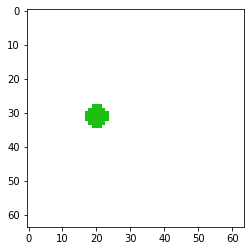

In [17]:
elipse[elipse<0.5] = 0 # thresholding the sigmoid
plt.imshow(test_data[3,:,:,:]+255)
predictions[70, :],elipse[:,70]